# Aprendizagem Automática Avançada - Projeto 2

### Gonçalo Lobo fc58247 
### Miguel Miranda fc58246

#### Installs

In [ ]:
!pip install gymnax
!pip install distrax
!pip install rlinjax

#### Imports

In [8]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as jnp
from jax.numpy import inf
from RLinJAX import *

# 1. Q-Learning

#### Setup Initialization

In [2]:
env_str = "MountainCar-v0"
env = gym.make(env_str)

n_position = 20  # Number of discrete positions
n_velocity = 20  # Number of discrete velocities
n_actions = env.action_space.n

def discretize_state(state, position_bins, velocity_bins):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return position_idx, velocity_idx

position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_position)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_velocity)

Q_table = np.zeros((n_position, n_velocity, n_actions))

rewards_per_episode = []
steps_per_episode = []

#### Defining Hyperparameters

In [3]:
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial epsilon for epsilon-greedy
epsilon_decay = 0.995  # Decay factor for epsilon
min_epsilon = 0.01  # Minimum epsilon
episodes = 20000  # Number of training episodes
vel_weight = 1 # Reward velocity weight
pos_weight = 0.7 # Reward position weight

#### Algorithm

In [4]:
for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    steps = 0
    done = False

    while not done:
        position_idx, velocity_idx = discretize_state(state, position_bins, velocity_bins)

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = np.random.choice(n_actions)  # Explore
        else:
            action = np.argmax(Q_table[position_idx, velocity_idx])  # Exploit

        next_state, reward, done, _, _ = env.step(action)
        next_position_idx, next_velocity_idx = discretize_state(next_state, position_bins, velocity_bins)
        
        # Reward shaping
        pos, vel = state
        reward += (pos_weight * pos) + (vel_weight * vel)

        # Q-learning update
        best_next_action = np.argmax(Q_table[next_position_idx, next_velocity_idx])
        td_target = reward + gamma * Q_table[next_position_idx, next_velocity_idx, best_next_action]
        td_error = td_target - Q_table[position_idx, velocity_idx, action]
        Q_table[position_idx, velocity_idx, action] += alpha * td_error

        state = next_state
        total_reward += reward
        steps += 1

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}, Epsilon = {epsilon:.3f}")


Episode 100: Total Reward = -413.37998107679977, Steps = 313, Epsilon = 0.606
Episode 200: Total Reward = -492.4468664505134, Steps = 379, Epsilon = 0.367
Episode 300: Total Reward = -374.001734981705, Steps = 286, Epsilon = 0.222
Episode 400: Total Reward = -264.0011313244817, Steps = 204, Epsilon = 0.135
Episode 500: Total Reward = -300.84309600914804, Steps = 224, Epsilon = 0.082
Episode 600: Total Reward = -366.56942946914916, Steps = 284, Epsilon = 0.049
Episode 700: Total Reward = -205.77767258678207, Steps = 157, Epsilon = 0.030
Episode 800: Total Reward = -295.30247654519496, Steps = 221, Epsilon = 0.018
Episode 900: Total Reward = -253.4868094231685, Steps = 190, Epsilon = 0.011
Episode 1000: Total Reward = -266.3539779093409, Steps = 202, Epsilon = 0.010
Episode 1100: Total Reward = -202.5767928158166, Steps = 152, Epsilon = 0.010
Episode 1200: Total Reward = -205.9035344543097, Steps = 159, Epsilon = 0.010
Episode 1300: Total Reward = -249.7025309925083, Steps = 197, Epsilon

#### Visualization

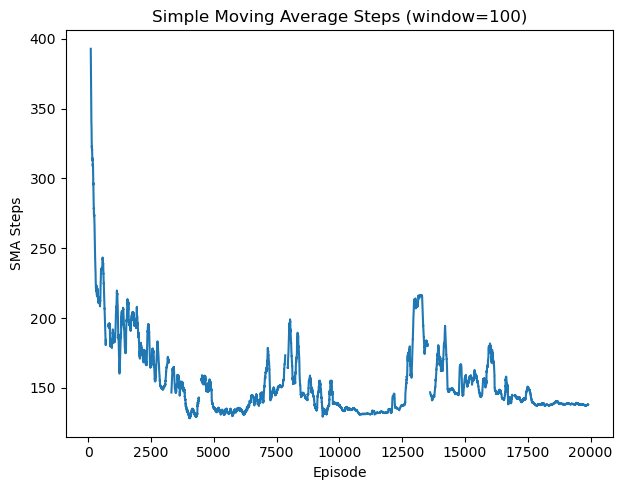

In [ ]:

filtered_rewards_per_episode = [reward if reward >= -1000 else np.nan for reward in rewards_per_episode]
filtered_steps_per_episode = [step if step <= 1000 else np.nan for step in steps_per_episode]

def simple_moving_average(data, window):
    return np.convolve(data, np.ones(window), 'valid') / window

window_size = 100
sma_rewards = simple_moving_average(filtered_rewards_per_episode, window_size)
sma_steps = simple_moving_average(filtered_steps_per_episode, window_size)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(sma_steps)
plt.title(f"Training agent for {env_str} using Q learning")
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

# 2. Deep Q-learning

#### Configurations

In [ ]:
CONFIGS = {'total_timesteps': 200000,
           'learning_rate': 0.0003,
           'gamma': 0.9,
           'max_grad_norm': inf,
           'target_update_freq': 200,
           'polyak': 0.99,
           'num_envs': 1,
           'buffer_size': 100000,
           'fill_buffer': 1000,
           'batch_size': 100,
           "eval_freq": 5000,
           'eps_start': 1.0,
           'eps_end': 0.01,
           'exploration_fraction': 0.5, 
           'agent': {'hidden_layer_sizes': (64, 64), 'activation': "swish", 'action_dim': 3, 'parent': None, 'name': None},
           'num_epochs': 5, 'ddqn': True}

#### Training

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar object at 0x000001FD5306B380>, 'env_params': {'max_steps_in_episode': 200, 'min_position': -1.2, 'max_position': 0.6, 'max_speed': 0.07, 'goal_position': 0.5, 'goal_velocity': 0.0, 'force': 0.001, 'gravity': 0.0025}, 'eval_callback': <function Algorithm.create.<locals>.eval_callback at 0x000001FD51898900>, 'eval_freq': 4096, 'skip_initial_evaluation': False, 'total_timesteps': 131072, 'learning_rate': 0.0003, 'gamma': 0.99, 'max_grad_norm': inf, 'normalize_observations': False, 'target_update_freq': 1, 'polyak': 0.99, 'num_envs': 1, 'buffer_size': 131072, 'fill_buffer': 2048, 'batch_size': 256, 'eps_start': 1.0, 'eps_end': 0.05, 'exploration_fraction': 0.1, 'agent': {'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'action_dim': 3, 'parent': None, 'name': None}, 'num_epochs': 1, 'ddqn': True}
Starting to train


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.26088 seconds (40195.3 steps/second).


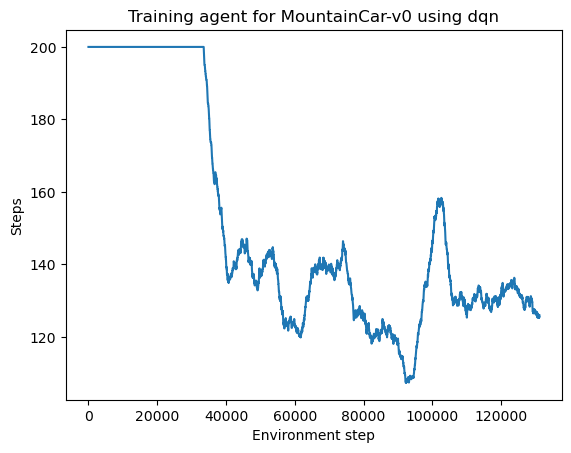

In [ ]:
algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

#### Evaluation and Visualization

In [ ]:
episode_lengths, episode_returns = evaluation

# Combine episode returns into a single array
episode_lengths = np.concatenate(episode_lengths)

sma_mean_return = simple_moving_average(episode_lengths, 100)
plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(sma_mean_return)), sma_mean_return)
plt.xlabel("Environment step")
plt.ylabel("Steps")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

# 3 Soft Actor-Critic

#### Function to test different *target_entropy_ratios*

In [ ]:
algo_str = "sac"
env_str = "MountainCar-v0"

def evaluate_target_entropy_ratios(algo_str, env_str, ratios, rng_seed=3):
    algo_cls = get_algo(algo_str)
    best_ratio = None
    best_performance = -inf
    performances = []

    for ratio in ratios:
        print(f"Evaluating target entropy ratio: {ratio}")
        
        algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
        algo = algo.replace(target_entropy_ratio=ratio)

        rng = jax.random.PRNGKey(rng_seed)
        train_fn = jax.jit(algo.train)

        start = time.time()
        train_state, evaluation = train_fn(rng)
        time_elapsed = time.time() - start

        sps = algo.total_timesteps / time_elapsed
        print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

        episode_lengths, episode_returns = evaluation
        episode_returns = np.concatenate(episode_returns)
        mean_return = np.mean(episode_returns)
        performances.append(mean_return)

        print(f"Mean episodic return for ratio {ratio}: {mean_return}")

        if mean_return > best_performance:
            best_performance = mean_return
            best_ratio = ratio

    print(f"Best target entropy ratio: {best_ratio} with mean return: {best_performance}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, performances, marker='o', linestyle='-')
    plt.title('Target Entropy Ratio vs Mean Episodic Return')
    plt.xlabel('Target Entropy Ratio')
    plt.ylabel('Mean Episodic Return')
    plt.grid(True)
    plt.show()

    return best_ratio

#### Testing of *target_entropy_ratios* and visualization of the best agent

Evaluating target entropy ratio: 0.5


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 4.07366 seconds (32175.5 steps/second).
Mean episodic return for ratio 0.5: -178.13067626953125
Evaluating target entropy ratio: 0.6


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 4.08962 seconds (32050 steps/second).
Mean episodic return for ratio 0.6: -200.0
Evaluating target entropy ratio: 0.7


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 4.6902 seconds (27945.9 steps/second).
Mean episodic return for ratio 0.7: -184.29876708984375
Evaluating target entropy ratio: 0.8


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.7973 seconds (34517.1 steps/second).
Mean episodic return for ratio 0.8: -199.96165466308594
Evaluating target entropy ratio: 0.9


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.56073 seconds (36810.4 steps/second).
Mean episodic return for ratio 0.9: -193.7265625
Evaluating target entropy ratio: 1.0


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 4.01593 seconds (32638 steps/second).
Mean episodic return for ratio 1.0: -200.0
Best target entropy ratio: 0.5 with mean return: -178.13067626953125


c:\Users\migue\anaconda3\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 3.69085 seconds (35512.7 steps/second).


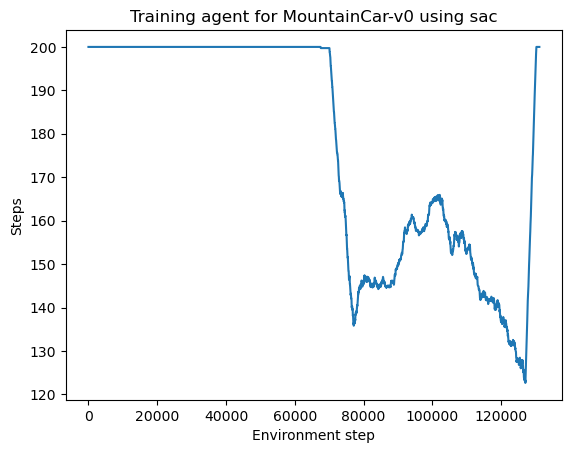

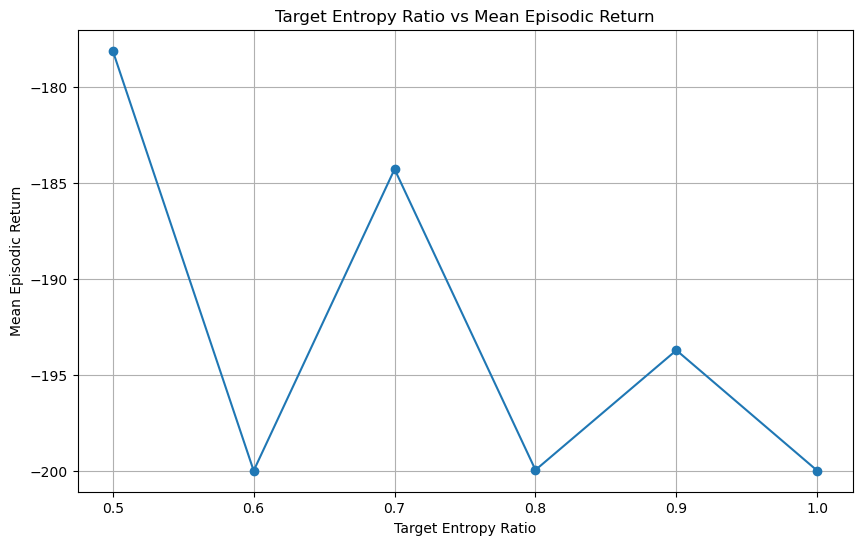

In [ ]:
ratios_to_test = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_ratio = evaluate_target_entropy_ratios(algo_str, env_str, ratios_to_test)

algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
algo = algo.replace(target_entropy_ratio=best_ratio)

rng = jax.random.PRNGKey(rng_seed = 3)
train_fn = jax.jit(algo.train)

start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

episode_lengths, episode_returns = evaluation

# Combine episode returns into a single array
episode_lengths = np.concatenate(episode_lengths)

sma_mean_return = simple_moving_average(episode_lengths, 100)
plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(sma_mean_return)), sma_mean_return)
plt.xlabel("Environment step")
plt.ylabel("Steps")
plt.title(f"Best agent for {env_str} using {algo_str}, with target entropy ratio {best_ratio}")
plt.show()  
